### Optimal control of the noisy phenomenological models, e.g. the FHN model
This notebook shows how to compute the optimal control signal for the noisy FHN model for a simple example task. Can be run analogously for the Hopf model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. In a deterministic system, the optimal control signal should converge to the input signal. In a noisy system, this should not be possible precisely, but only approximately, depending on the noise strength.

In [2]:
# We import the model
model = FHNModel()
# model = HopfModel()
model.params.sigma_ou = 0.

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 40.
amplitude = 1.
period = duration/4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.
y_init = 0.
model.params["xs_init"] = np.array([[x_init]])
model.params["ys_init"] = np.array([[y_init]])

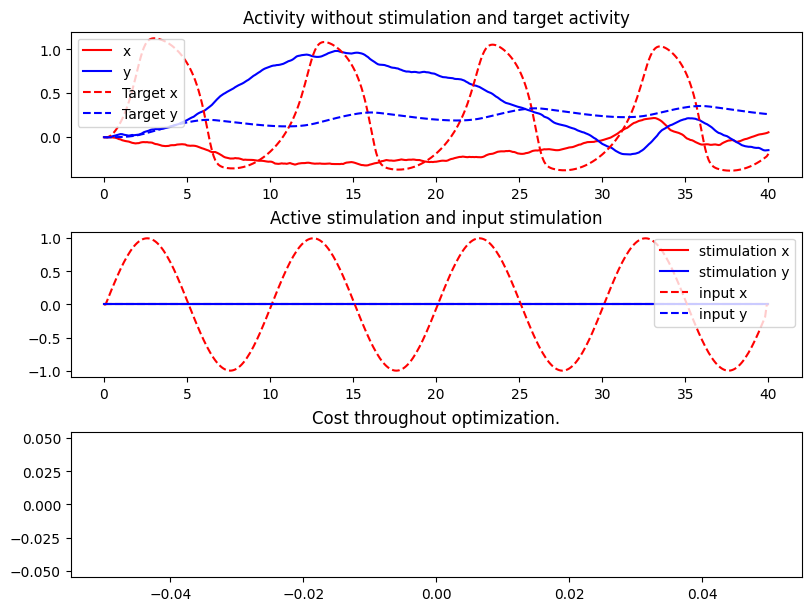

In [3]:
# We set the stimulus in x and y variables, and run the simulation in a noise-free system
model.params["x_ext"] = input
model.params["y_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation with noise
# Change sigma_ou_parameter to adjust the noise strength
model.params['sigma_ou'] = 0.1
model.params['tau_ou'] = 1.
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

The target is a periodic oscillation of x and y variable (computed in deterministic, noise-free system).

The noisy, undistrubed system fluctuates around zero.

For the optimization, you can now set several new parameters:
- M: the number of noise realizations that the algorithm averages over. Default=1
- M_validation: the number of noise realization the final cost is computed from. Default=1000
- validate_per_step: If True, the cost for each step is computed averaging over M_validation instead of M realizations, this takes much longer. Default=False
- method: determines, how the noise averages are computed. Results may vary for different methods depending on the specific task. Choose from ['3']. Default='3'

Please note:
- higher number of iterations does not promise better results for computations in noisy systems. The cost will level off at some iteration number, and start increasing again afterwards. Make sure not to perform too many iterations.
- M, M_validation should increase with sigma_ou model parameter
- validate_per_step does not impact the control result

Let's optimize with the following parameters: M=20, method='3', iterations=100

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Mean cost in iteration 0: 9.865966803047037
Diverging model output, decrease step size to 2.5.
Diverging model output, decrease step size to 0.625.
Diverging model output, decrease step size to 0.15625.
Mean cost in iteration 1: 9.474062866472863
Mean cost in iteration 2: 9.425379873424848
Mean cost in iteration 3: 9.264379525505396
Mean cost in iteration 4: 9.277128818813722
Mean cost in iteration 5: 9.219745658848037
Mean cost in iteration 6: 9.2357681633811
Mean cost in iteration 7: 9.288253380948253
Mean cost in iteration 8: 9.278830331437966
Mean cost in iteration 9: 9.184940741287088
Mean cost in iteration 10: 9.288446720653871
Minimal cost found at iteration 9
Final cost validated with 500 noise realizations : 9.274776291387433


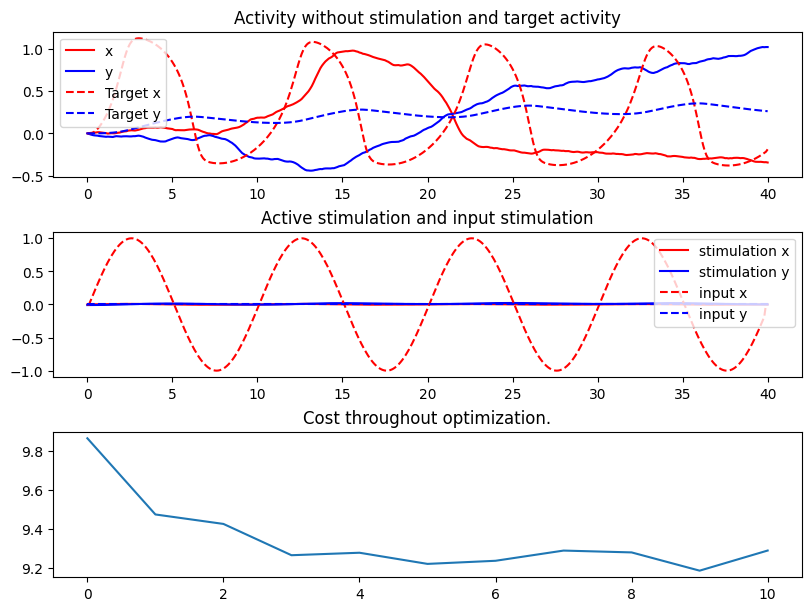

In [4]:


# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, print_array=np.arange(0,101,1),
                                M=20, M_validation=500, validate_per_step=True)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, print_array=np.arange(0,101,10),
                                  M=20, M_validation=500, validate_per_step=True)

# We run 100 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(10)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)


Let's do the same thing with different parameters: M=100, method='3', iterations=30

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Mean cost in iteration 0: 10.145017085586446
Diverging model output, decrease step size to 2.5.
Diverging model output, decrease step size to 0.625.
Mean cost in iteration 5: 8.559509745927151
Mean cost in iteration 10: 7.011056334883367
Mean cost in iteration 15: 6.148354366418402
Mean cost in iteration 20: 6.085538039964103
Mean cost in iteration 25: 6.074924437121997
Mean cost in iteration 30: 6.085910866050402
Minimal cost found at iteration 19
Final cost validated with 500 noise realizations : 5.973380061682116


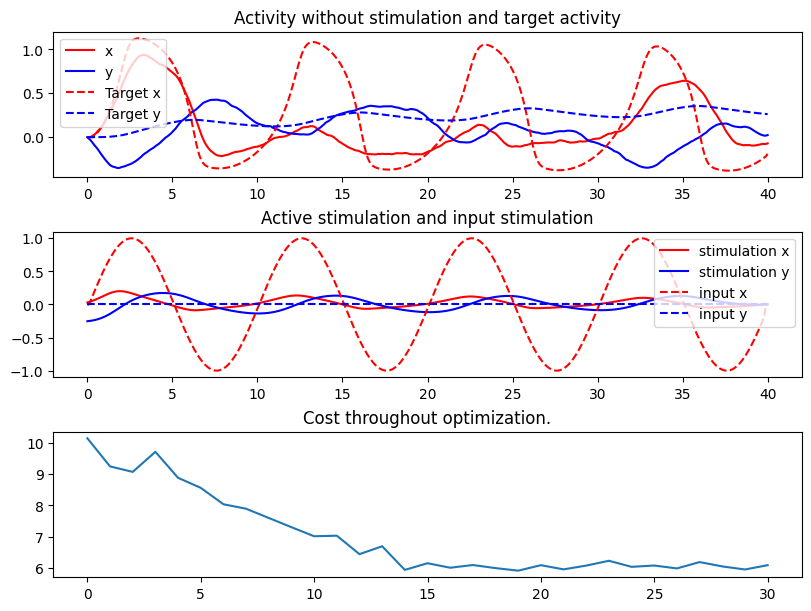

In [5]:
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, print_array=np.arange(0,31,5),
                                M=100, M_validation=500, validate_per_step=True)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, print_array=np.arange(0,31,5),
                                 M=100, M_validation=500, validate_per_step=True)

model_controlled.optimize(30)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Apparently, for this problem, the first approach is more efficient.

The larger M leads to a more steady decrease in cost in the second approach.

### Network case

Let us know study a simple 2-node network of noisy FHN oscillators. Each population in each node incorporates noise.We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

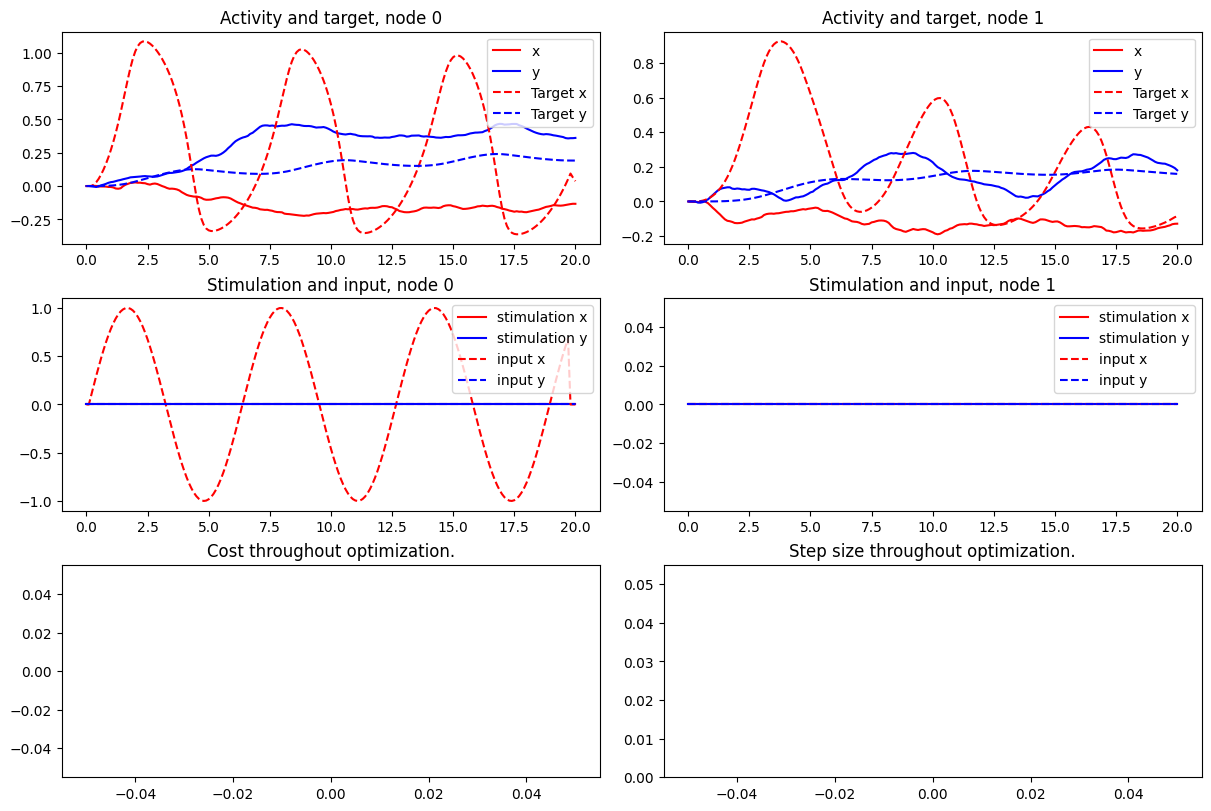

In [6]:
cmat = np.array( [[0., 0.], [1., 0.]] )  # diagonal elements are zero, connection stregth is 1 (0.) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

if model.name == 'fhn':
    model = FHNModel(Cmat=cmat, Dmat=dmat)
elif model.name == 'hopf':
    model = HopfModel(Cmat=cmat, Dmat=dmat)

model.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    model.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

# noise free target
model.params['sigma_ou'] = 0.

duration = 20.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["xs_init"] = np.vstack( [x_init, x_init] )
model.params["ys_init"] = np.vstack( [y_init, y_init] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params['sigma_ou'] = 0.1
model.params['tau_ou'] = 1.
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Let's optimize with the following parameters: M=20, method='3', iterations=100

Compute control for a noisy system
Mean cost in iteration 0: 0.529882826844608
Mean cost in iteration 10: 0.5139033353390813
Mean cost in iteration 20: 0.5409890370815597
Mean cost in iteration 30: 0.5393505955425165
Mean cost in iteration 40: 0.5340596176424265
Mean cost in iteration 50: 0.5138348172440695
Mean cost in iteration 60: 0.45262834438452054
Mean cost in iteration 70: 0.48935005654794933
Mean cost in iteration 80: 0.542870466621023
Mean cost in iteration 90: 0.5041390103967869
Mean cost in iteration 100: 0.5171720370514772
Minimal cost found at iteration 60
Final cost validated with 500 noise realizations : 0.5267506466529055


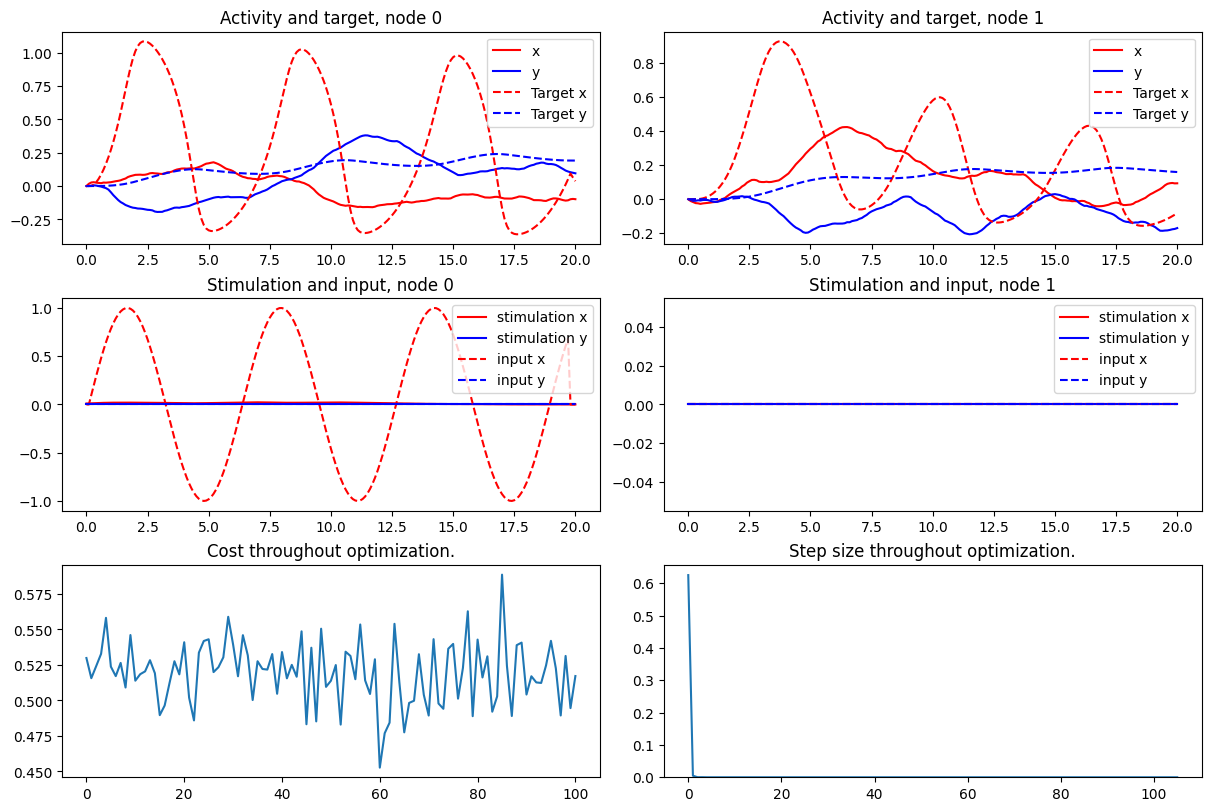

In [8]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,1] = 1. # only measure in y-channel in node 1

model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model,
                                target,
                                print_array=np.arange(0,101,10),
                                control_matrix=control_mat,
                                cost_matrix=prec_mat,
                                M=20,
                                M_validation=500,
                                validate_per_step=True)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model,
                                  target,
                                  print_array=np.arange(0,101,10),
                                  control_matrix=control_mat,
                                  cost_matrix=prec_mat,
                                  M=20,
                                  M_validation=500,
                                  validate_per_step=True)

model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Let's do the same thing with different parameters: M=100, method='3', iterations=30

Compute control for a noisy system
Mean cost in iteration 0: 0.5669966205401789
Mean cost in iteration 5: 0.5433222080612584
Mean cost in iteration 10: 0.5178581821253064
Mean cost in iteration 15: 0.5346652951039527
Mean cost in iteration 20: 0.5480725119557297
Mean cost in iteration 25: 0.5847645111968467
Mean cost in iteration 30: 0.5006342244097318
Minimal cost found at iteration 6
Final cost validated with 500 noise realizations : 0.536865335165568


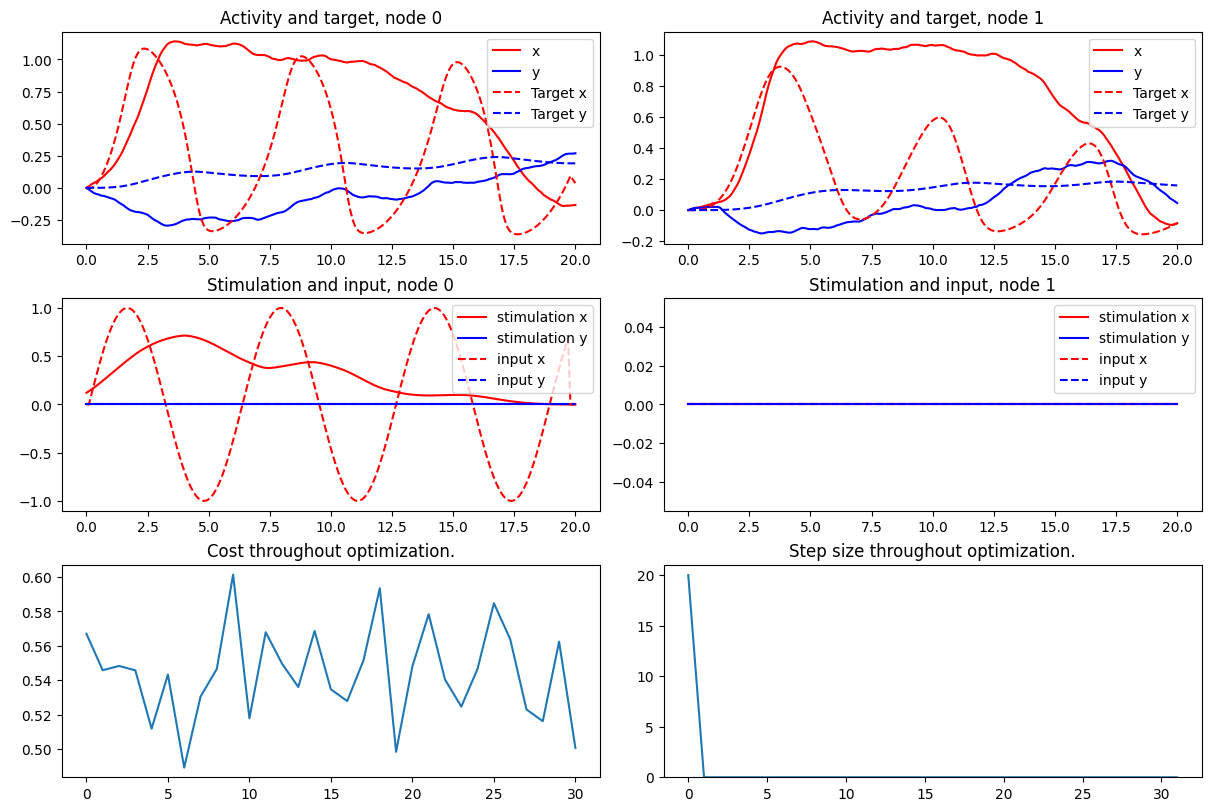

In [9]:
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model,
                                target,
                                print_array=np.arange(0,31,5),
                                control_matrix=control_mat,
                                cost_matrix=prec_mat,
                                M=100,
                                M_validation=500,
                                validate_per_step=True)

elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model,
                                target,
                                print_array=np.arange(0,31,5),
                                control_matrix=control_mat,
                                cost_matrix=prec_mat,
                                M=100,
                                M_validation=500,
                                validate_per_step=True)

model_controlled.optimize(30)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

This time, the two approaches seem similarly successful.